## FOOOFGroup

<div class="alert alert-success">
This tutorial covers running FOOOF across multiple PSDs, using FOOOFGroup, an object derived from the base FOOOF object.
</div>

<div class="alert alert-info">
For a more specific exploration of the FOOOF object, and the underlying algorithm, go [here](02-FOOOF.ipynb).
</div>

In [1]:
# Set matplotlib for plotting in the notebook
%matplotlib inline

# FOOOF imports: get FOOOF & FOOOFGroup objects
from fooof import FOOOFGroup

# Import some utilities for synthesizing some test data
from fooof.utils import mk_freq_vector
from fooof.synth import mk_fake_group_data

### Synthesize PSDs

FOOOF includes some basic support for creating synthetic power-spectra, that mimic real data. 

Here we will use that functionality to create a matrix of PSDs to test with. 

In [2]:
#  This function will create PSDs with slope values randomly chosen from {1.5, 2.0, 2.5}
#    with oscillations potentially added, with CF of either 10 or 20 Hz.
freqs, psds = mk_fake_group_data(mk_freq_vector([3, 40], 0.5), n_psds=10)

### FOOOFGroup

The FOOOFGroup object is very similar to the FOOOF object (programmatically, it inherits from the FOOOF object), and can be used in the same way. The main difference is that instead of running across a single PSD, it operates across matrices of multiple PSDs. 

The main different with the FOOOFGroup object, is that it also contains a 'psds' attribute, which stores the matrix of power-spectra to be fit, and collects fit results into a 'group_results' attributes. Otherwise, FOOOFGroup supports all the same functionality, accessed in the same way as the FOOOF object.

Note that, under the hood, it runs the exact same fitting procedure, per PSD, as the FOOOF object.

In [3]:
# Initialize a FOOOFGroup object. It accepts all the same settings as FOOOF()
fg = FOOOFGroup(bandwidth_limits=[1, 8], min_amp=0.05, max_n_oscs=6)

In [4]:
# Fit a group of PSDs with the .fit() method
#  The key difference, as compared to FOOOF, is that it takes a 2D array of PSDs, in the shape [n_psds, n_freqs]
fg.fit(freqs, psds)

In [5]:
# Print out results
fg.print_results()


                                        FOOOF - GROUP RESULTS                                       

                                  Number of PSDs in the Group: 10                                   

                   The input PSDs were modelled in the frequency range: 3 - 40 Hz                   
                                  Frequency Resolution is 0.50 Hz                                   

                                   PSDs were fit without a knee.                                    

                                      Background Slope Values                                       
                               Min: 1.4967, Max: 2.5311, Mean: 1.8630                               

                       In total 9 oscillations were extracted from the group                        

                                        Fitting Performance                                         
                             R2s -  Min: 0.9987, Max: 1.0000, Mean: 0.9996          

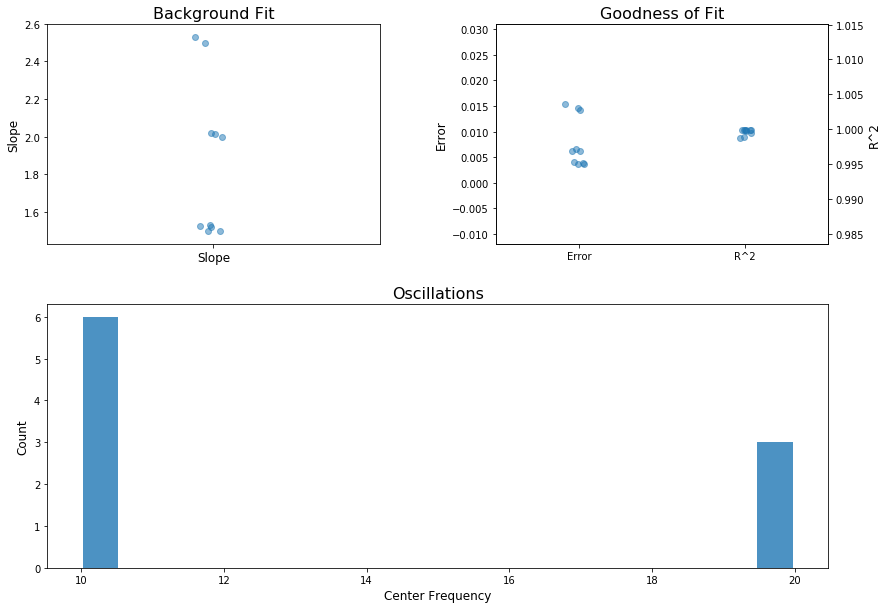

In [6]:
# Plot a summary of the results across the group
#  Note: given the simulations, we expect slopes at {1.5, 2.0. 2.5} and oscillations around {10, 20}
fg.plot()

In [7]:
# Just as with the FOOOF object, you can call 'model' to runs the fitting, and print results & plots
#  In this case, the results printed will be summary data across the group of PSDs
# fg.model(freqs, psds)

In [8]:
# You can also create reports for FOOOFGroup fits
#  This also saves out a pdf report, with the plot and results (same as above) collected together
fg.create_report()

In [9]:
# Check what the generated report looks like
from IPython.display import IFrame
IFrame("FOOOFGroup_Report.pdf", width=950, height=1200)

### FOOOFGroup Data

Words, words, words.

In [10]:
# As it runs, FOOOFGroup collects each fit results in 'group_results'
#  'group_results' is a list of FOOOFResult objects
fg.group_results[0:2]

[FOOOFResult(background_params=array([ 20.02993481,   2.02032572]), oscillation_params=array([[ 10.03837513,   0.48465123,   3.81290035]]), r2=0.999835896247803, error=0.0066399628034919068, gaussian_params=array([[ 10.03837513,   0.48474943,   1.90645018]])),
 FOOOFResult(background_params=array([ 35.06036624,   1.52951771]), oscillation_params=array([[ 10.11195656,   0.47344298,   3.684001  ],
       [ 19.97689111,   0.2723914 ,   7.2358742 ]]), r2=0.99891150161823739, error=0.014252310211074265, gaussian_params=array([[ 10.11195656,   0.46822689,   1.8420005 ],
       [ 19.97689111,   0.2723967 ,   3.6179371 ]]))]

In [11]:
# In order to parse this data, and retrieve specific results, you can use the 'get_all_data' method
#  'get_all_data' let's you grab data by specifying a FOOOFResult field and (optionally) an index
sls = fg.get_all_data('background_params', 1)
cfs = fg.get_all_data('oscillation_params', 0)

In [12]:
# Check the fit center-frequencies and slope values
print(cfs)
print(sls)

[ 10.03837513  10.11195656  19.97689111  10.01807615  10.02962012
  10.09719994  19.97143241  10.10268607  19.94313648]
[ 2.02032572  1.52951771  1.49670948  1.51735989  1.99789184  2.01399932
  2.53109815  2.49767143  1.52723466  1.49814317]


### Saving & Loading with FOOOFGroup

Words, words, words.

In [13]:
# Save out FOOOFGroup results
fg.save(save_results=True)

In [14]:
# You can then reload this group data
nfg = FOOOFGroup()
nfg.load()

In [15]:
# Print results to check that the loaded group 
nfg.print_results()


                                        FOOOF - GROUP RESULTS                                       

                                  Number of PSDs in the Group: 10                                   

                   The input PSDs were modelled in the frequency range: 3 - 40 Hz                   
                                  Frequency Resolution is 0.50 Hz                                   

                                   PSDs were fit without a knee.                                    

                                      Background Slope Values                                       
                               Min: 1.4967, Max: 2.5311, Mean: 1.8630                               

                       In total 9 oscillations were extracted from the group                        

                                        Fitting Performance                                         
                             R2s -  Min: 0.9987, Max: 1.0000, Mean: 0.9996          

TODO: Notes on saving.

### Parallel Support

FOOOFGroup also has support for running in parallel.

The fit method includes an optional parameter 'n_jobs', which if set at 1, will run FOOOF linearly, but otherwise will launch n_jobs number of jobs, in parallel. Setting n_jobs to -1 will launch in parallel across all available cores. 

Note, however, that running FOOOF in parallel does not gaurantee a quicker runtime overall. The computation time per FOOOF-fit scales with the frequency range fit over, and the 'complexity' of the PSDs, in terms of number of oscillations. For relatively small numbers of PSDs (less than ~100), across relatively small frequency ranges (say ~3-40Hz), may offer no appreciable speed up. 

In [16]:
# Run FOOOF fit across PSDs in parallel, using all cores
fg.fit(freqs, psds, n_jobs=-1)

### Plotting Individual Fits

When running FOOOF across a group of PSDs, results are stored as the FOOOFResults, which store (only) the results of the model fit, not the full model fits themselves. To examine individual model fits, FOOOFGroup can regenerate FOOOF objects for individual PSDs, with the full model available for visualization.

In [17]:
# Extract a particular PSD, specified by index to a FOOOF object, and set to regenerate the PSD model
fm = fg.get_fooof(ind=2, regenerate=True)


                                          FOOOF - PSD MODEL                                         

                    The input PSD was modelled in the frequency range: 3 - 40 Hz                    
                                  Frequency Resolution is 0.50 Hz                                   

                              Background Parameters (offset, slope):                                
                                          34.9964, 1.4967                                           

                                     0 oscillations were found:                                     

                                     R^2 of model fit is 0.9999                                     
                           Root mean squared error of model fit is 0.0041                           



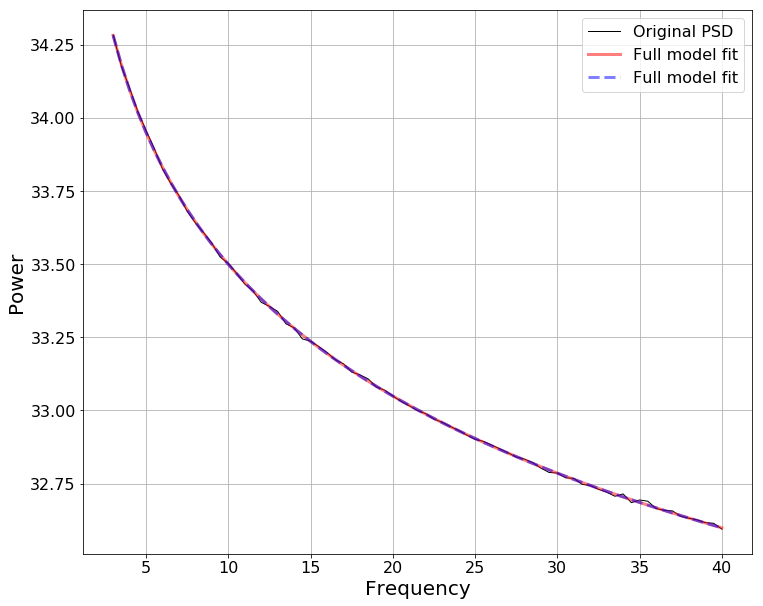

In [18]:
# Print results and plot extracted PSD fit
fm.print_results()
fm.plot()

<div class="alert alert-info">
To continue with the tutorial, with more examples of setting parameters, getting good fits, and troubleshooting issues, go [here](05-Tuning&Troubleshooting.ipynb).
</div>